# Ray Data: Image Classification

In [29]:
import ray

ray.init(address="ray://54.235.55.121:10001/")

SIGTERM handler is not set because current thread is not the main thread.


RuntimeError: Version mismatch: The cluster was started with:
    Ray: 2.10.0
    Python: 3.9.18
This process on Ray Client was started with:
    Ray: 2.10.0
    Python: 3.11.9


In [2]:
s3_uri = "s3://anonymous@air-example-data-2/imagenette2/train/"

ds = ray.data.read_images(s3_uri, mode="RGB")

ds

Dataset(num_rows=9469, schema={image: numpy.ndarray(ndim=3, dtype=uint8)})

In [3]:
single_batch = ds.take_batch(10)

2024-07-14 13:02:01,713	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-07-14_13-01-43_006469_1970/logs/ray-data.log


2024-07-14 13:02:01,714	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage] -> LimitOperator[limit=10]



- ReadImage 1:   0%|          | 0/200 [00:00<?, ?it/s]

- limit=10 2:   0%|          | 0/200 [00:00<?, ?it/s]

Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

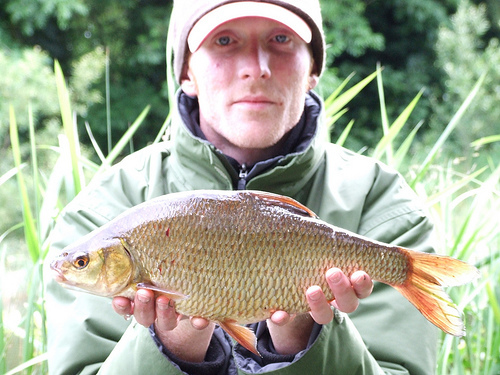

In [6]:
from PIL import Image

img = Image.fromarray(single_batch["image"][0])
img

In [7]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [8]:
import torch
from torchvision.models import ResNet152_Weights
from torchvision import transforms
from torchvision import models

weights = ResNet152_Weights.IMAGENET1K_V1

# Load the pretrained resnet model and move to GPU if one is available.

device = torch.device("cuda" if torch.cuda.is_available() else "mps")

model = models.resnet152(weights=weights).to(device)

model.eval()

imagenet_transforms = weights.transforms
transform = transforms.Compose([transforms.ToTensor(), imagenet_transforms()])

In [9]:
transformed_batch = [transform(image) for image in single_batch["image"]]
with torch.inference_mode():
    prediction_results = model(torch.stack(transformed_batch).to(device))
    classes = prediction_results.argmax(dim=1).cpu()

del model  # Free up GPU memory

labels = [weights.meta["categories"][i] for i in classes]
labels

['tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'bittern',
 'coho',
 'tench']

## Scaling with Ray Data

In [10]:
import numpy as np
from typing import Dict

def preprocess_image(row: Dict[str, np.ndarray]):
    return {
        "original_image": row["image"],
        "transformed_image": transform(row["image"]),
    }

In [11]:
transformed_ds = ds.map(preprocess_image)

In [12]:
from typing import Dict
import numpy as np
import torch


class ResnetModel:
    def __init__(self):
        self.weights = ResNet152_Weights.IMAGENET1K_V1
        self.device = torch.device("cuda" if torch.cuda.is_available() else "mps")
        self.model = models.resnet152(weights=self.weights).to(self.device)
        self.model.eval()

    def __call__(self, batch: Dict[str, np.ndarray]):
        # Convert the numpy array of images into a PyTorch tensor.
        # Move the tensor batch to GPU if available.
        torch_batch = torch.from_numpy(batch["transformed_image"]).to(self.device)
        with torch.inference_mode():
            prediction = self.model(torch_batch)
            predicted_classes = prediction.argmax(dim=1).detach().cpu()
            predicted_labels = [
                self.weights.meta["categories"][i] for i in predicted_classes
            ]
            return {
                "predicted_label": predicted_labels,
                "original_image": batch["original_image"],
            }

In [21]:
predictions = (
    transformed_ds
    .map_batches(
        ResnetModel,
        concurrency=2,  # Use 4 GPUs. Change this number based on the number of GPUs in your cluster.
        num_gpus=0,  # Specify 1 GPU per model replica.
        batch_size=32,  # Use the largest batch size that can fit on our GPUs
    )
)

In [22]:
prediction_batch = predictions.materialize()

2024-07-14 18:47:40,419	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-07-14_13-01-43_006469_1970/logs/ray-data.log
2024-07-14 18:47:40,420	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> ActorPoolMapOperator[ReadImage->Map(preprocess_image)->MapBatches(ResnetModel)]



- ReadImage->Map(preprocess_image)->MapBatches(ResnetModel) 1:   0%|          | 0/200 [00:00<?, ?it/s]

Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

(raylet) Spilled 2438 MiB, 292 objects, write throughput 261 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(raylet) Spilled 4846 MiB, 361 objects, write throughput 223 MiB/s.


In [25]:
prediction_batch.take_all()

KeyboardInterrupt: 

In [23]:
for image, prediction in zip(
    prediction_batch["original_image"], prediction_batch["predicted_label"]
):
    img = Image.fromarray(image)
    display(img)
    print("Label: ", prediction)

TypeError: 'MaterializedDataset' object is not subscriptable